In [1]:
import cv2
import os
import csv
import numpy as np
import itertools
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn

Using TensorFlow backend.


In [2]:
class_names = {1: 'EOSINOPHIL', 2: 'LYMPHOCYTE', 3: 'MONOCYTE', 4:'NEUTROPHIL'}

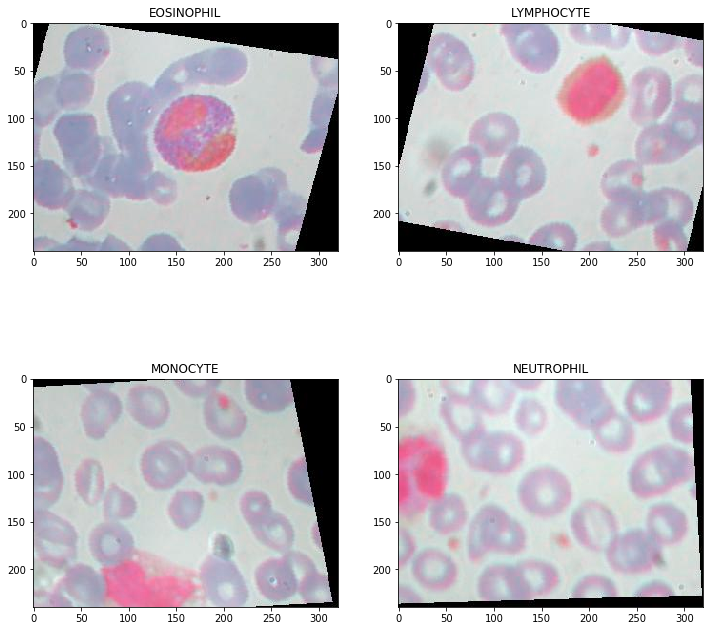

In [3]:
images = [
    'dataset2-master/images/TRAIN/EOSINOPHIL/_0_1169.jpeg',
    'dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg',
    'dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg',
    'dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
]
fig = plt.figure(figsize=(12, 12))

for i in range(1, 5):
    img = cv2.imread(images[i-1])
    fig.add_subplot(2, 2, i)
    plt.title(class_names[i])
    plt.imshow(img)
plt.show()

In [4]:
training_data_folder = 'dataset2-master/images/TRAIN/'
testing_data_folder = 'dataset2-master/images/TEST/'

In [5]:
wbc_labels = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL':3}

In [6]:
import scipy.misc
def get_data(folder):
    data = []
    labels = []
    for wbc_type in os.listdir(folder):
        for file in tqdm(os.listdir(folder + wbc_type)):
            img_file = cv2.imread(folder + wbc_type + '/' + file)
            if img_file is not None:
                img_file = Image.fromarray(img_file)
                img_file = img_file.resize((80,60),3)
                img_arr = np.asarray(img_file)
                data.append(img_arr)
                labels.append(wbc_labels[wbc_type])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [7]:
training_data, training_labels = get_data(training_data_folder)
testing_data, testing_labels = get_data(testing_data_folder)

In [8]:
from keras.utils.np_utils import to_categorical
training_label_hot = to_categorical(training_labels, num_classes=4)
testing_label_hot = to_categorical(testing_labels, num_classes=4)
print(wbc_labels)

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


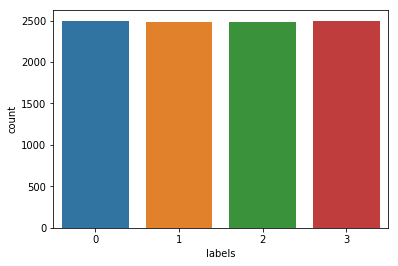

In [9]:
import seaborn as sns
df = pd.DataFrame()
df["labels"]=training_labels
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(wbc_labels)

In [11]:
training_data=np.array(training_data)
training_data=training_data/255.0

testing_data=np.array(testing_data)
testing_data=testing_data/255.0

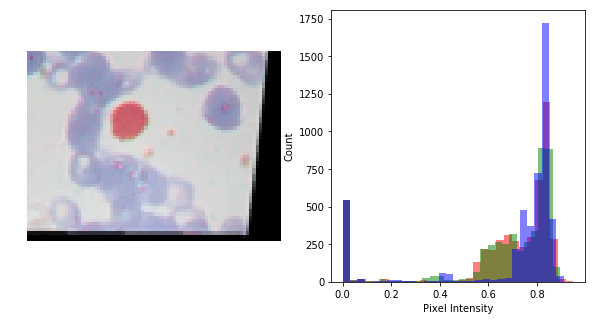

In [12]:
plotHistogram(training_data[1])

In [13]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [14]:
import keras
wbc_labels = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL':3}
def runKerasCNNAugment(a,b,c,d,e):
    batch_size = 128
    num_classes = len(b[0])
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=60,80
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = wbc_labels
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(wbc_labels.values())) 
    plt.show()
runKerasCNNAugment(training_data,training_label_hot,testing_data,testing_label_hot,1)

Epoch 1/30
312/311 [==============================] - 183s 586ms/step - loss: 1.4393 - acc: 0.2779 - val_loss: 1.5909 - val_acc: 0.2509
Epoch 2/30
312/311 [==============================] - 180s 577ms/step - loss: 1.2925 - acc: 0.3845 - val_loss: 1.2090 - val_acc: 0.4274
Epoch 3/30
312/311 [==============================] - 180s 576ms/step - loss: 1.1682 - acc: 0.4628 - val_loss: 1.0589 - val_acc: 0.5078
Epoch 4/30
312/311 [==============================] - 184s 588ms/step - loss: 1.0760 - acc: 0.5107 - val_loss: 1.2063 - val_acc: 0.4926
Epoch 5/30
312/311 [==============================] - 185s 594ms/step - loss: 1.0152 - acc: 0.5479 - val_loss: 0.8855 - val_acc: 0.6144
Epoch 6/30
312/311 [==============================] - 180s 578ms/step - loss: 0.9252 - acc: 0.5853 - val_loss: 1.1322 - val_acc: 0.5010
Epoch 7/30
312/311 [==============================] - 181s 582ms/step - loss: 0.8582 - acc: 0.6195 - val_loss: 0.7664 - val_acc: 0.6610
Epoch 8/30
312/311 [============================

TypeError: object of type 'int' has no len()